## Dataset Analysis & Preparation

Let's start with the following points:

- Download and examine the attached dataset (mentioned in the document)
- Understand the structure: labels (hire/not hire), and any demographic indicators
- Identify how sensitive attributes (gender-indicative names, pronouns) are present in the data
- Create the training/test split with intentional representation imbalance

## Dataset Download

I'm currently working on `colab`, so I downloaded the dataset and uploaded it to the machine. If ou're working locally you just have to change the `data_path`.

Let's now load all of our data into a pandas dataframe.

In [62]:
import os
import pandas as pd
import numpy as np
import torch

## changed according to the path of the dataset
data_path = './data.csv'

full_df = pd.read_csv(data_path)

In [63]:
full_df

,Age,Gender,EducationLevel,ExperienceYears,PreviousCompanies,DistanceFromCompany,InterviewScore,SkillScore,PersonalityScore,RecruitmentStrategy,HiringDecision
0,26,1,2,0,3,26.783828,48,78,91,1,1
1,39,1,4,12,3,25.862694,35,68,80,2,1
2,48,0,2,3,2,9.920805,20,67,13,2,0
3,34,1,2,5,2,6.407751,36,27,70,3,0
4,30,0,1,6,1,43.105343,23,52,85,2,0
...,...,...,...,...,...,...,...,...,...,...,...
1495,48,0,2,3,4,9.183783,66,3,80,3,1
1496,27,1,2,10,3,14.847731,43,97,7,2,0
1497,24,1,1,1,2,4.289911,31,91,58,1,1
1498,48,0,2,4,4,36.299263,9,37,44,2,1


# Generate Resume Text
To simulate a real-world screening model, we're expected to generate a synthetic `Resume_Text` field from the available features. For that we'll use template with variiations that shows the biases that can arise as Gender is explicitly mentioned and it is feature rich.

> We can use LLMs especially free ones like the ones provided inb the huggingface `transformers` library, but we'll use a template.

> NB: for gender, I assumed that 0--> male, 1 --> female, following this https://www.kaggle.com/datasets/rabieelkharoua/predicting-hiring-decisions-in-recruitment-data

In [64]:
import random

def generate_resume_text_variations(row):
    """
    Generate variations of the resume text to add diversity
    """
    age = row['Age']
    gender = 'male' if row['Gender']==0 else 'female'
    education = row['EducationLevel']
    experience = row['ExperienceYears']
    prev_companies = row['PreviousCompanies']
    interview_score = row['InterviewScore']
    skill_score = row['SkillScore']
    personality_score = row['PersonalityScore']
    strategy = row['RecruitmentStrategy']

    # Different sentence structures for variety
    templates = [
        f"I am a {gender} candidate, {age} years old, with a {education} degree and {experience} years of experience across {prev_companies} companies. I scored {interview_score} in the interview, with a skill score of {skill_score} and personality score of {personality_score}. I applied through {strategy}.",

        f"As a {gender} professional aged {age}, I hold a {education} degree and bring {experience} years of experience from {prev_companies} different companies. My interview performance was {interview_score}, complemented by a skill score of {skill_score} and personality score of {personality_score}. I discovered this opportunity through {strategy}.",

        f"I am a {age}-year-old {gender} candidate with a {education} degree. My professional background includes {experience} years of experience across {prev_companies} organizations. I achieved an interview score of {interview_score}, with technical skills rated at {skill_score} and personality assessment at {personality_score}. My application came through {strategy}.",

        f"Profile: {gender} candidate, age {age}, educational background {education}. Professional experience spans {experience} years across {prev_companies} companies. Assessment results: interview score {interview_score}, skill evaluation {skill_score}, personality rating {personality_score}. Application source: {strategy}.",

        f"I represent a {gender} applicant of {age} years with {education} education. My career encompasses {experience} years of experience gained across {prev_companies} different organizations. Performance metrics include interview score of {interview_score}, skill assessment of {skill_score}, and personality evaluation of {personality_score}. I found this position through {strategy}."
    ]

    return random.choice(templates)

In [65]:
def add_resume_text_column(df, use_variations=True):
    """
    Add Resume_Text column to the dataframe

    Parameters:
    df: pandas DataFrame with the required columns
    use_variations: boolean, if True uses varied templates, if False uses standard format
    """
    df = df.copy()

    df['Resume_Text'] = df.apply(generate_resume_text_variations, axis=1)

    return df

Let's now see how our generated text looks like after applying it to our dataframe.

In [66]:
with_text_df=add_resume_text_column(full_df)
with_text_df['Resume_Text']

,Resume_Text
0,"As a female professional aged 26.0, I hold a 2..."
1,"As a female professional aged 39.0, I hold a 4..."
2,I am a 48.0-year-old male candidate with a 2.0...
3,I am a 34.0-year-old female candidate with a 2...
4,I am a 30.0-year-old male candidate with a 1.0...
...,...
1495,"Profile: male candidate, age 48.0, educational..."
1496,"Profile: female candidate, age 27.0, education..."
1497,I am a 24.0-year-old female candidate with a 1...
1498,I am a 48.0-year-old male candidate with a 2.0...


Now we started with the generated text, let's try to make a BERT classification.
> Maybe as a next step, we could've used a transformer model to generate the text.

# Data Splitting

Before initializing our model, let's split training and testing with representation imbalance.
> Remember that 0 in the Gender column, stands for male. While 1 is for female.

Let's first see how many males are there

## Representation Imbalance

Split across training and test sets with representation imbalance (e.g., more male resumes in training). This will be very important to be used in bias detection that can happen in real life.

In [67]:
with_text_df[with_text_df['Gender']==0].count()

,0
Age,762
Gender,762
EducationLevel,762
ExperienceYears,762
PreviousCompanies,762
DistanceFromCompany,762
InterviewScore,762
SkillScore,762
PersonalityScore,762
RecruitmentStrategy,762


As you can see we have 762 males in our dataset, let's say we'll have 650 of those in the training dataset.

In [68]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

def imbalanced_split(df, male_train_ratio=0.95, female_train_ratio=0.1):
    """
    Imbalanced split preserving all DataFrame columns
    Parameters:
    df: DataFrame with 'Gender' and 'Resume_Text' columns (and other columns)
    male_train_ratio: Proportion of males for training (0.8 = 80%)
    female_train_ratio: Proportion of females for training (0.4 = 40%)
    Returns:
    train_df, test_df: Full DataFrames with all original columns
    """
    # Separate male and female
    male_df = df[df['Gender'] == 0].copy()
    female_df = df[df['Gender'] == 1].copy()

    # Split males according to male_train_ratio
    male_train, male_test = train_test_split(
        male_df,
        train_size=male_train_ratio,
        random_state=42,
        shuffle=True
    )

    # Split females
    female_train, female_test = train_test_split(
        female_df,
        train_size=female_train_ratio,
        random_state=42,
        shuffle=True
    )

    # Combine train and test sets
    train_df = pd.concat([male_train, female_train], ignore_index=True)
    test_df = pd.concat([male_test, female_test], ignore_index=True)

    # Shuffle the combined datasets
    train_indices = np.random.RandomState(42).permutation(len(train_df))
    test_indices = np.random.RandomState(42).permutation(len(test_df))

    train_df = train_df.iloc[train_indices].reset_index(drop=True)
    test_df = test_df.iloc[test_indices].reset_index(drop=True)

    return train_df, test_df

In [69]:
train_df, test_df = imbalanced_split(with_text_df)
test_df

,Age,Gender,EducationLevel,ExperienceYears,PreviousCompanies,DistanceFromCompany,InterviewScore,SkillScore,PersonalityScore,RecruitmentStrategy,HiringDecision,Resume_Text
0,37,1,2,8,3,40.150012,96,96,83,1,1,I represent a female applicant of 37.0 years w...
1,49,1,3,0,1,23.222048,68,92,61,3,0,I represent a female applicant of 49.0 years w...
2,21,1,1,14,4,7.461190,42,100,36,1,1,"As a female professional aged 21.0, I hold a 1..."
3,22,1,2,15,4,42.659583,25,49,46,1,0,"I am a female candidate, 22.0 years old, with ..."
4,20,1,2,1,2,21.706576,73,70,11,1,1,"As a female professional aged 20.0, I hold a 2..."
...,...,...,...,...,...,...,...,...,...,...,...,...
699,36,1,2,8,5,37.496176,40,33,68,2,0,I represent a female applicant of 36.0 years w...
700,29,1,2,2,4,45.970626,14,79,71,2,0,I am a 29.0-year-old female candidate with a 2...
701,48,1,2,9,2,49.804301,52,42,82,2,0,"As a female professional aged 48.0, I hold a 2..."
702,28,1,4,3,1,34.090536,88,45,60,1,1,"Profile: female candidate, age 28.0, education..."


As you can see from the head, the training dataset is more male than female. Also it's shuffled well enough.

In [70]:
# train dataset X, y
X_train = train_df['Resume_Text']
y_train = train_df['HiringDecision']
# test dataset X, y
X_test = test_df['Resume_Text']
y_test = test_df['HiringDecision']

In [71]:
X_train.head(10)

,Resume_Text
0,I represent a male applicant of 44.0 years wit...
1,I am a 33.0-year-old female candidate with a 2...
2,"Profile: male candidate, age 46.0, educational..."
3,I represent a male applicant of 40.0 years wit...
4,"I am a male candidate, 37.0 years old, with a ..."
5,"As a female professional aged 41.0, I hold a 4..."
6,"Profile: male candidate, age 32.0, educational..."
7,I represent a male applicant of 28.0 years wit...
8,"I am a male candidate, 40.0 years old, with a ..."
9,I am a 45.0-year-old male candidate with a 2.0...


# Model Definition

Forn our purposes, we'll use a pre-trained BERT model, that will be fine-tuned on our dataset. Let's see how the BERT model can tokenize a sample text

Make sure you run on GPU

In [72]:
print(torch.cuda.is_available())  # Should return True if GPU is ready

True


Let's use the model above and define it.

## Tokenization

Tokenization is the process of converting a sequence of text into individual units or tokens. These tokens are the smallest pieces of text that are meaningful for the task being performed. Tokenization is typically the first step in the text preprocessing pipeline in NLP.



In [73]:
from transformers import AutoTokenizer

# Initialize the BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

sample_text = X_train[1]
print(sample_text)
tokens = tokenizer(sample_text, padding="max_length", truncation=True, max_length=128)

I am a 33.0-year-old female candidate with a 2.0 degree. My professional background includes 2.0 years of experience across 2.0 organizations. I achieved an interview score of 75.0, with technical skills rated at 73.0 and personality assessment at 61.0. My application came through 2.0.


Let's first see the lengths of the tokenized `Resume_Text`.

In [74]:
lengths = [len(tokenizer(x)["input_ids"]) for x in X_train]
lengths[:10]

[70, 71, 59, 70, 65, 68, 59, 70, 65, 71]

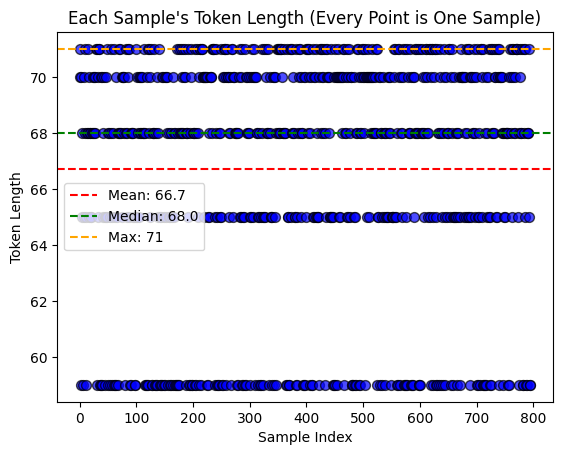

In [75]:
import matplotlib.pyplot as plt

sample_indices = range(len(lengths))
plt.scatter(sample_indices, lengths, alpha=0.7, s=50, color='blue', edgecolors='black')
plt.axhline(np.mean(lengths), color='red', linestyle='--',
                   label=f'Mean: {np.mean(lengths):.1f}')
plt.axhline(np.median(lengths), color='green', linestyle='--',
                   label=f'Median: {np.median(lengths):.1f}')
plt.axhline(np.max(lengths), color='orange', linestyle='--',
            label=f'Max: {np.max(lengths)}')
plt.xlabel('Sample Index')
plt.ylabel('Token Length')
plt.title('Each Sample\'s Token Length (Every Point is One Sample)')
plt.legend()

As you can see, the lengths are well defined in 5 lines. This is because our templates had only 5 possibilities.

Our max is 71 tokens
96 gives us a 35% buffer (71 × 1.35 ≈ 96)

In [76]:
def tokenize(example):
    return tokenizer(
        example["Resume_Text"],
        padding="max_length",
        truncation=True,
        max_length=96,
    )


## Datasets & Dataloaders

Since we already defined our tokenization function above, we can directly use it and return it in the form of pytorch's `Dataset`.

In [77]:
from torch.utils.data import Dataset, DataLoader

class ResumeDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Create example dict in the format your tokenize function expects
        example = {"Resume_Text": self.texts[idx]}

        # Use your existing tokenization function
        tokenized = tokenize(example)

        return {
            'input_ids': torch.tensor(tokenized['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(tokenized['attention_mask'], dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }


In [78]:
train_dataset = ResumeDataset(X_train, y_train)
test_dataset = ResumeDataset(X_test, y_test)

Now, let's define our dataloaders.

In [79]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
eval_dataloader = DataLoader(test_dataset, batch_size=16)

## Pre-trained Model Loading

In [80]:
from transformers import AutoModelForSequenceClassification

# Initialize a BERT model for binary classification
model_name = "bert-base-uncased"
## set num_labels=2 for binary classification
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,  # Single output for binary classification
    id2label={0: "not_hired", 1: "hired"},
    label2id={"not_hired": 0, "hired": 1}
)

print(model.config)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "not_hired",
    "1": "hired"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "hired": 1,
    "not_hired": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.53.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



## Fine-tune the Model
for fine-tuning purposes we'll leave the same model.

In [81]:
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Trainable parameters: 109483778


## Training Regime
Now let's define the training regime for our model. We'll use pure pytorch.

In [82]:
from torch.optim import AdamW
from transformers import get_scheduler
from torch.nn.utils import clip_grad_norm_
from torch.cuda.amp import autocast, GradScaler
from transformers import get_cosine_schedule_with_warmup


optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 15
total_steps = len(train_dataloader) * num_epochs

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),  # 10% warmup
    num_training_steps=total_steps
)

scaler = GradScaler()
loss_fn = torch.nn.CrossEntropyLoss()

/tmp/ipython-input-82-3507884421.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [83]:
model.train()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    total_loss = 0
    num_batches = 0

    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()

        with autocast():  # Mixed precision for speed
            outputs = model(**batch)
            logits = outputs.logits
            loss = loss_fn(logits, batch["labels"])

        scaler.scale(loss).backward()

        # Unscale before clipping
        scaler.unscale_(optimizer)
        clip_grad_norm_(model.parameters(), max_norm=1.0)

        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        # Accumulate loss for averaging
        total_loss += loss.item()
        num_batches += 1

    # Print average loss, not last batch loss
    avg_loss = total_loss / num_batches
    print({
        "epoch": epoch,
        "loss": avg_loss,  # Average loss across all batches
        "lr": scheduler.get_last_lr()[0],
    })

/tmp/ipython-input-83-4254466922.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision for speed


{'epoch': 0, 'loss': 0.6465360510349274, 'lr': 3.3333333333333335e-05}
{'epoch': 1, 'loss': 0.5274396896362304, 'lr': 4.983095894354858e-05}
{'epoch': 2, 'loss': 0.49468634247779847, 'lr': 4.849231551964771e-05}
{'epoch': 3, 'loss': 0.48235415130853654, 'lr': 4.588719528532342e-05}
{'epoch': 4, 'loss': 0.47920814514160154, 'lr': 4.215604094671835e-05}
{'epoch': 5, 'loss': 0.5406532669067383, 'lr': 3.7500000000000003e-05}
{'epoch': 6, 'loss': 0.4891694897413254, 'lr': 3.217008081777726e-05}
{'epoch': 7, 'loss': 0.478599573969841, 'lr': 2.6453620722761896e-05}
{'epoch': 8, 'loss': 0.4739298629760742, 'lr': 2.0658795558326743e-05}
{'epoch': 9, 'loss': 0.4405787527561188, 'lr': 1.509800584902108e-05}
{'epoch': 10, 'loss': 0.42096778869628904, 'lr': 1.0071035207430352e-05}
{'epoch': 11, 'loss': 0.36965493515133857, 'lr': 5.848888922025553e-06}
{'epoch': 12, 'loss': 0.34946912139654157, 'lr': 2.659183991914696e-06}
{'epoch': 13, 'loss': 0.3179342016577721, 'lr': 6.738782355044049e-07}
{'epoc

## Training our model

# Fairness Metrics

s. The computation of group fairness metrics is best understood as the result of a disaggregated analysis, in which we measure the extent to which a particular metric differs across groups of individuals.
Calculating group fairness metrics:
*   Demographic parity
*   Equal opportunity
*   Average odds difference






## Demographic Parity

Demographic parity requires that the positive prediction rate is the same across all groups, regardless of the true outcome.

**What it measures:** Whether your model gives positive predictions at the same rate for different groups

In [84]:
!pip install fairlearn;

In [85]:
from fairlearn.metrics import demographic_parity_difference, demographic_parity_ratio
from transformers import pipeline

# Create a classification pipeline
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

X_test_texts = X_test.tolist()

sensitive_test_data = test_df['Gender']

y_test_pred = classifier(X_test_texts)

## cleanup the test predictions
y_pred = [int(pred['label']=='hired') for pred in y_test_pred]

print("Demographic Parity difference:")
print(demographic_parity_difference(y_test, y_pred,
                                   sensitive_features = sensitive_test_data))

print("Demographic Parity Ratio")
print(demographic_parity_ratio(y_test, y_pred,
                                   sensitive_features = sensitive_test_data))

Device set to use cuda:0


Demographic Parity difference:
0.1060728744939271
Demographic Parity Ratio
0.6850961538461539


This indicates that our model is not so robust! We should see the model's distribution

In [86]:
print("Test set gender distribution:")
print(test_df['Gender'].value_counts(normalize=True))

print("\nHiring rates by gender:")
print(test_df.groupby('Gender')['HiringDecision'].mean())

Test set gender distribution:
Gender
1    0.944602
0    0.055398
Name: proportion, dtype: float64

Hiring rates by gender:
Gender
0    0.256410
1    0.303759
Name: HiringDecision, dtype: float64


Let's make the same for the `train_df`

In [87]:
print("Train set gender distribution:")
print(train_df['Gender'].value_counts(normalize=True))

print("\nHiring rates by gender:")
print(train_df.groupby('Gender')['HiringDecision'].mean())

Train set gender distribution:
Gender
0    0.908291
1    0.091709
Name: proportion, dtype: float64

Hiring rates by gender:
Gender
0    0.313970
1    0.356164
Name: HiringDecision, dtype: float64


From we can see, despite having around 88.5% males in the test dataframe and only 11.5% females, the hiring decision is pretty similar for both genders. 28.5% and 30.9% respectively. If we wanted more demographic parity, we could've biased the outcomes 'HiringDecision', not just the genders.
But let's see how our model does on other metrics.

## Equal Opportunity

In the hiring example, equal opportunity requires that the males who are qualified to be hired are just as likely to be chosen as individuals in females who are qualified to be hired. In `Fairlearn`, equal opportunity is called `true_positive_rate`.

In [88]:
from fairlearn.metrics import MetricFrame, true_positive_rate

print("Equal Opportunity")
metric_frame = MetricFrame(
    metrics={'tpr': true_positive_rate},
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=sensitive_test_data
)

print("TPR by group:")
print(metric_frame.by_group)

Equal Opportunity
TPR by group:
             tpr
Gender          
0       0.700000
1       0.767327


We have a a nearly 4% difference between both, this is not so good!

## Average Odds Difference

Average Odds Difference is a fairness metric that combines both True Positive Rate (TPR) and False Positive Rate (FPR) differences between groups. It's essentially the average of the TPR and FPR differences.

In [89]:
from fairlearn.metrics import true_positive_rate_difference, false_positive_rate_difference, false_positive_rate

## true positive rate difference between both genders
TPR_diff = true_positive_rate_difference(y_test, y_pred, sensitive_features=sensitive_test_data)
print("True Positive Rate Difference between genders")
print(f'{TPR_diff*100:.2f}%')

## false positive rate difference between both genders
FPR_diff = false_positive_rate_difference(y_test, y_pred, sensitive_features=sensitive_test_data)
print("False Positive Rate Difference between genders")
print(f'{FPR_diff*100:.2f}%')


True Positive Rate Difference between genders
6.73%
False Positive Rate Difference between genders
8.01%


In [90]:
## Average odds difference

print('Average Odds difference')
AVG_odds = (TPR_diff+ FPR_diff) / 2
print(f'{AVG_odds*100:.2f}%')

Average Odds difference
7.37%


## Visualizations

Here we'll have more visualizations to plot the fairness of our model. Let's plot disparities across genders.

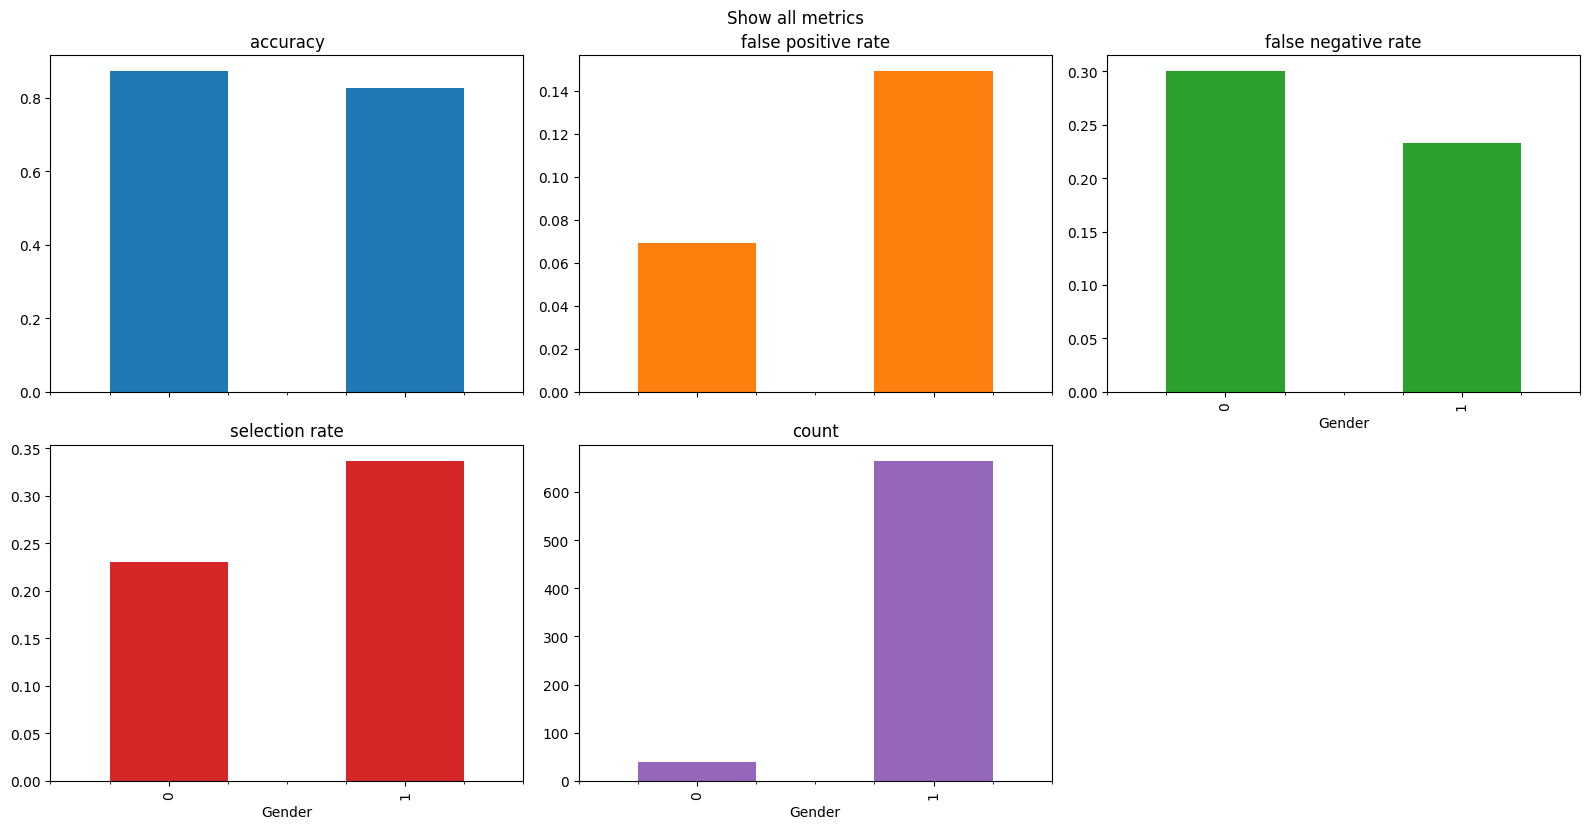

In [91]:
from fairlearn.metrics import (
    MetricFrame,
    count,
    false_negative_rate,
    false_positive_rate,
    selection_rate,
)
from sklearn.metrics import accuracy_score, precision_score

# Analyze metrics using MetricFrame
metrics = {
    "accuracy": accuracy_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
    "count": count,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_test_data
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[16, 12],
    title="Show all metrics",
)
plt.subplots_adjust(
    hspace=0.4,  # Height spacing between subplots
    wspace=0.3,  # Width spacing between subplots
    bottom=0.8  # Bottom margin
)

plt.tight_layout()
plt.show()

The false positive rate is so high for females & the false negative is higher for males. This means that women are wrongly being offered jobs, they don't deserve & males are wrongly rejected for jobs. This means that unqualified women get jobs while qualified men don't get jobs. This however is not exactly true, as from the count we'll see a greater disparity between females and males, this means that probabilistically speaking the model may bbe doing the same exact jobs for both genders butr because there are more females, then the model shows to be biased.

# Explainability using SHAP

## Prediction Function

In [92]:
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)

def prediction(input_text):

    if type(input_text) == str:
        texts = [input_text]
    elif type(input_text) == list :
        texts = input_text
    else:
        texts = input_text.tolist()
    predictions = classifier(texts)
    y_pred_probs = []
    for pred in predictions:
            if len(pred) == 2:  # Binary classification
                # Find the probability for the positive class (hired)
                hired_prob = next(p['score'] for p in pred if p['label'].lower()=='hired')
                not_hired_prob = 1 - hired_prob
                y_pred_probs.append([not_hired_prob, hired_prob])
    return np.array(y_pred_probs)


Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


## SHAP explainer


In [93]:
import shap


def create_shap_explainer(texts, max_evals=100):
    """Create SHAP explainer with background data"""
    print("Creating SHAP explainer...")

    # Use a subset of background texts for efficiency
    if len(texts) > 50:
        background_sample = np.random.choice(texts, 50, replace=False)
    else:
        background_sample = texts

    # Create partition explainer
    explainer = shap.Explainer(
        prediction,
        masker=shap.maskers.Text(tokenizer),
        max_evals=max_evals
    )

    print("SHAP explainer created successfully!")
    return explainer

## Decipher Explanation

In [94]:
def explain_predictions(explainer, texts_to_explain, class_names=['No-Hire', 'Hire']):
    """Generate SHAP explanations for given texts"""
    print(f"Generating explanations for {len(texts_to_explain)} texts...")

    # SHAP values
    shap_values = explainer(texts_to_explain)

    # results
    explanations = []

    for i, text in enumerate(texts_to_explain):
        # Get prediction
        prediction_probs = prediction([text])[0]
        predicted_class = np.argmax(prediction_probs)
        confidence = prediction_probs[predicted_class]

        explanation = {
            'text': text,
            'predicted_class': class_names[predicted_class],
            'confidence': confidence,
            'prediction_probs': prediction_probs,
            'shap_values': shap_values[i],
            'tokens': shap_values[i].data
        }

        explanations.append(explanation)

    return explanations

## Get Data

In [95]:
def get_data(X_test, y_test, hires=3, no_hires=2):
    """ Get 5 texts that predicts 3 hires & 2 no-hires"""

    # text to be explained
    text_data = []

    for index in range(len(X_test)):
        print("Index", index)
        # hire is 1, no hire is 0
        pred_value = np.argmax(prediction(X_test[index]))
        ## no hire
        if (pred_value == 0 and no_hires>0):
            no_hires= no_hires-1
            print("value:", pred_value)
            text_data.append(X_test[index])

        ## hire
        elif (pred_value == 1 and hires>0):
            hires = hires -1
            print("value:", pred_value)
            text_data.append(X_test[index])
        elif (hires==0 and no_hires==0):
            break
        else:
            continue

    return text_data


## Shap Explanation

In [96]:
background_texts = X_test.tolist()
# Create SHAP explainer
explainer = create_shap_explainer(background_texts)

# data
data = get_data(X_test, y_test)
series_data = pd.Series(data)
print("type of background_texts", type(series_data))
# Generate explanations
explanations = explain_predictions(explainer, series_data)

Creating SHAP explainer...
SHAP explainer created successfully!
Index 0
value: 1
Index 1
value: 0
Index 2
value: 1
Index 3
value: 1
Index 4
value: 0
Index 5
type of background_texts <class 'pandas.core.series.Series'>
Generating explanations for 5 texts...


PartitionExplainer explainer: 6it [00:13,  6.74s/it]


## Visualization

In [97]:
def visualize_explanations(explanations, max_display=5):
    """Create visualizations for SHAP explanations"""
    print("Creating visualizations...")

    # Create figure with subplots
    fig, axes = plt.subplots(min(len(explanations), max_display), 1,
                            figsize=(15, 4*min(len(explanations), max_display)))

    if min(len(explanations), max_display) == 1:
        axes = [axes]

    for i, exp in enumerate(explanations[:max_display]):
        # Get SHAP values for the predicted class
        predicted_class_idx = 1 if exp['predicted_class'] == 'Hire' else 0
        shap_vals = exp['shap_values'].values[:, predicted_class_idx]
        tokens = exp['tokens']

        # Create horizontal bar plot
        # Get top 15 most important tokens
        token_importance = list(zip(tokens, shap_vals))
        token_importance.sort(key=lambda x: abs(x[1]), reverse=True)
        top_tokens = token_importance[:15]

        if top_tokens:
            tokens_display = [t[0] for t in top_tokens]
            importance_values = [t[1] for t in top_tokens]

            colors = ['red' if val < 0 else 'green' for val in importance_values]

            axes[i].barh(range(len(tokens_display)), importance_values, color=colors, alpha=0.7)
            axes[i].set_yticks(range(len(tokens_display)))
            axes[i].set_yticklabels(tokens_display)
            axes[i].set_xlabel('SHAP Value (Feature Importance)')
            axes[i].set_title(f'Prediction: {exp["predicted_class"]} (Confidence: {exp["confidence"]:.3f})')
            axes[i].grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.show()


Creating visualizations...


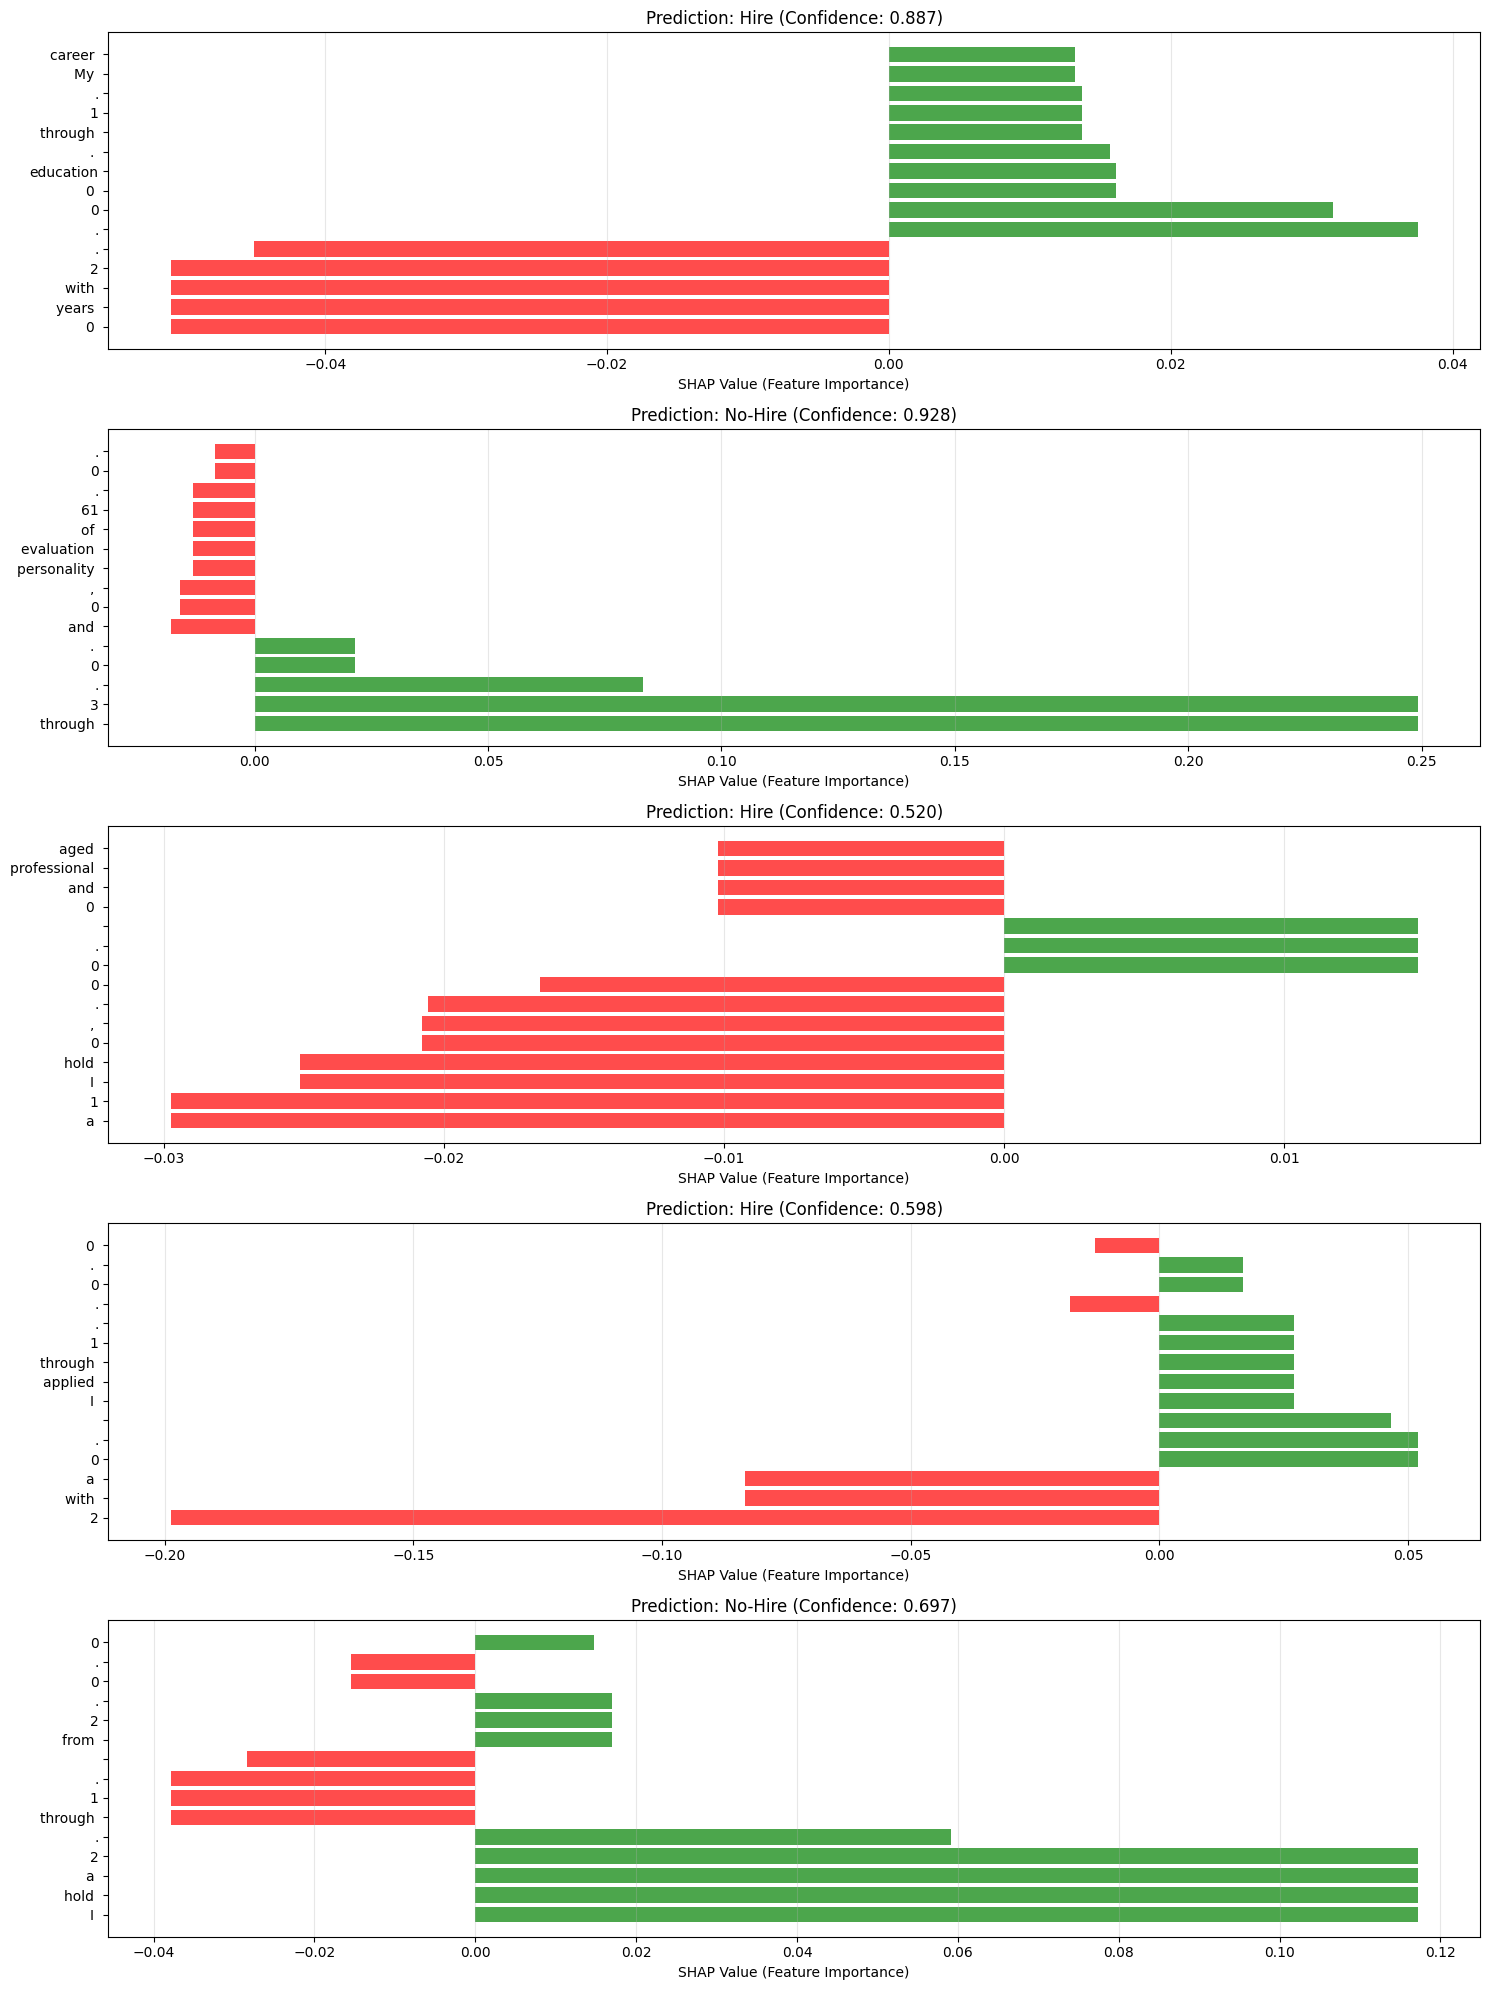

In [98]:
visualize_explanations(explanations)

# Gender-Correlation
Attribute feature importance and analyze if gender-correlated terms (like names or pronouns) are influencing decisions.

## Analyzing Bias

In [99]:
from collections import defaultdict

def analyze_gender_bias(explanations):
    """Simplified gender bias analysis for 'male' and 'female' terms only."""
    print("Analyzing gender bias in explanations...")

    bias_results = {
        'term_importance': {'male': [], 'female': []},
        'biased_predictions': []
    }

    for exp in explanations:
        tokens = exp['tokens']
        shap_vals = exp['shap_values'].values

        # Get SHAP values for predicted class
        class_idx = 1 if exp['predicted_class'] == 'Hire' else 0
        importances = shap_vals[:, class_idx]

        gender_score = 0
        detected_terms = []

        for i, token in enumerate(tokens):
            word = token.lower().strip()
            importance = importances[i]

            if word == 'male':
                bias_results['term_importance']['male'].append(importance)
                detected_terms.append(('male', importance))
                gender_score += importance
            elif word == 'female':
                bias_results['term_importance']['female'].append(importance)
                detected_terms.append(('female', importance))
                gender_score += importance

        if detected_terms:
            bias_results['biased_predictions'].append({
                'text': exp['text'][:100] + '...' if len(exp['text']) > 100 else exp['text'],
                'prediction': exp['predicted_class'],
                'confidence': exp['confidence'],
                'gender_score': gender_score,
                'detected_terms': detected_terms
            })

    return bias_results


## Printing Bias

In [100]:
def print_bias_report(bias_results):
    """Print simplified gender bias report for 'male' and 'female' terms."""
    print("\n--- GENDER BIAS REPORT ---")

    # Term-level importance
    for term in ['male', 'female']:
        scores = bias_results['term_importance'][term]
        if scores:
            avg_importance = sum(scores) / len(scores)
            print(f"\nTerm: '{term}'")
            print(f"  Occurrences: {len(scores)}")
            print(f"  Average importance: {avg_importance:.4f}")
        else:
            print(f"\nTerm: '{term}' — not detected.")

    # Biased predictions
    if bias_results['biased_predictions']:
        print("\n--- BIASED PREDICTIONS ---")
        for i, pred in enumerate(bias_results['biased_predictions'], 1):
            print(f"\n#{i}:")
            print(f"  Text: {pred['text']}")
            print(f"  Prediction: {pred['prediction']} (Confidence: {pred['confidence']:.3f})")
            print(f"  Gender score: {pred['gender_score']:.4f}")
            for term, importance in pred['detected_terms']:
                print(f"    → {term}: importance={importance:.4f}")
    else:
        print("\nNo biased predictions detected.")

    print("\n--------------------------")


In [101]:
# Analyze bias
bias_results = analyze_gender_bias(explanations)

# Print reports
print_bias_report(bias_results)

Analyzing gender bias in explanations...

--- GENDER BIAS REPORT ---

Term: 'male' — not detected.

Term: 'female'
  Occurrences: 5
  Average importance: 0.0013

--- BIASED PREDICTIONS ---

#1:
  Text: I represent a female applicant of 37.0 years with 2.0 education. My career encompasses 8.0 years of ...
  Prediction: Hire (Confidence: 0.887)
  Gender score: 0.0044
    → female: importance=0.0044

#2:
  Text: I represent a female applicant of 49.0 years with 3.0 education. My career encompasses 0.0 years of ...
  Prediction: No-Hire (Confidence: 0.928)
  Gender score: -0.0003
    → female: importance=-0.0003

#3:
  Text: As a female professional aged 21.0, I hold a 1.0 degree and bring 14.0 years of experience from 4.0 ...
  Prediction: Hire (Confidence: 0.520)
  Gender score: -0.0090
    → female: importance=-0.0090

#4:
  Text: I am a female candidate, 22.0 years old, with a 2.0 degree and 15.0 years of experience across 4.0 c...
  Prediction: Hire (Confidence: 0.598)
  Gender score:

# Bias Mitigation

## Counterfactual Data Augmentation

We apply **Counterfactual Data Augmentation (CDA)** to reduce gender bias in the dataset. This involves generating new examples by flipping gendered terms (e.g., “he” ↔ “she”, “man” ↔ “woman”) to balance the representation.

We compare model **accuracy** and **fairness metrics** before and after augmentation.


In [102]:
def generate_counterfactual(text):
    swaps = {
        ' he ': ' she ', ' she ': ' he ',
        ' his ': ' her ', ' her ': ' his ',
        ' him ': ' her ', ' her ': ' him ',
        ' man ': ' woman ', ' woman ': ' man ',
        ' male ': ' female ', ' female ': ' male '
    }
    text_cf = text
    for orig, alt in swaps.items():
        text_cf = text_cf.replace(orig, alt)
    return text_cf

In [103]:
cf_df = train_df.copy() ## copying the dataframe
data = train_df.copy()

cf_df['Resume_Text'] = cf_df['Resume_Text'].apply(generate_counterfactual)

# Combine original and counterfactual data
augmented_df = pd.concat([data, cf_df], ignore_index=True).sample(frac=1.0, random_state=42)

# train dataset X, y
X_train2 = augmented_df['Resume_Text']
y_train2 = augmented_df['HiringDecision']

## New Datasets & Dataloaders

In [104]:
train_dataset2 = ResumeDataset(X_train2, y_train2)
train_dataloader2 = DataLoader(train_dataset2, batch_size=16, shuffle=True)

## Retrain The model

In [105]:
model2 = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,  # Single output for binary classification
    id2label={0: "not_hired", 1: "hired"},
    label2id={"not_hired": 0, "hired": 1}
)

optimizer = AdamW(model2.parameters(), lr=5e-5)
num_epochs = 15
total_steps = len(train_dataloader2) * num_epochs

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),  # 10% warmup
    num_training_steps=total_steps
)

scaler = GradScaler()
loss_fn = torch.nn.CrossEntropyLoss()

model2.train()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2.to(device)

for epoch in range(num_epochs):
    total_loss = 0
    num_batches = 0

    for batch in train_dataloader2:
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()

        with autocast():  # Mixed precision for speed
            outputs = model2(**batch)
            logits = outputs.logits
            loss = loss_fn(logits, batch["labels"])

        scaler.scale(loss).backward()

        # Unscale before clipping
        scaler.unscale_(optimizer)
        clip_grad_norm_(model2.parameters(), max_norm=1.0)

        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        # Accumulate loss for averaging
        total_loss += loss.item()
        num_batches += 1

    # Print average loss, not last batch loss
    avg_loss = total_loss / num_batches
    print({
        "epoch": epoch,
        "loss": avg_loss,  # Average loss across all batches
        "lr": scheduler.get_last_lr()[0],
    })

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-105-1925818925.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-105-1925818925.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision for speed


{'epoch': 0, 'loss': 0.5713528060913086, 'lr': 3.3333333333333335e-05}
{'epoch': 1, 'loss': 0.5009083557128906, 'lr': 4.983095894354858e-05}
{'epoch': 2, 'loss': 0.4819232940673828, 'lr': 4.849231551964771e-05}
{'epoch': 3, 'loss': 0.4521571159362793, 'lr': 4.588719528532342e-05}
{'epoch': 4, 'loss': 0.42151615142822263, 'lr': 4.215604094671835e-05}
{'epoch': 5, 'loss': 0.3281869411468506, 'lr': 3.7500000000000003e-05}
{'epoch': 6, 'loss': 0.2647578716278076, 'lr': 3.217008081777726e-05}
{'epoch': 7, 'loss': 0.2091495156288147, 'lr': 2.6453620722761896e-05}
{'epoch': 8, 'loss': 0.1350637900829315, 'lr': 2.0658795558326743e-05}
{'epoch': 9, 'loss': 0.10560140967369079, 'lr': 1.509800584902108e-05}
{'epoch': 10, 'loss': 0.06940401583909989, 'lr': 1.0071035207430352e-05}
{'epoch': 11, 'loss': 0.052126803398132325, 'lr': 5.848888922025553e-06}
{'epoch': 12, 'loss': 0.04841130644083023, 'lr': 2.659183991914696e-06}
{'epoch': 13, 'loss': 0.037991870790719987, 'lr': 6.738782355044049e-07}
{'e

## Fairness Metrics (on new model)

In [106]:
classifier2 = pipeline("text-classification", model=model2, tokenizer=tokenizer)

X_test_texts = X_test.tolist()

sensitive_test_data = test_df['Gender']

y_test_pred = classifier2(X_test_texts)

Device set to use cuda:0


In [107]:
## cleanup the test predictions
y_pred = [int(pred['label']=='hired') for pred in y_test_pred]

print("Demographic Parity difference:")
print(demographic_parity_difference(y_test, y_pred,
                                   sensitive_features = sensitive_test_data))

print("Demographic Parity Ratio")
print(demographic_parity_ratio(y_test, y_pred,
                                   sensitive_features = sensitive_test_data))

Demographic Parity difference:
0.04576826682089841
Demographic Parity Ratio
0.8603857915784521


In [108]:
print("Equal Opportunity")
metric_frame = MetricFrame(
    metrics={'tpr': true_positive_rate},
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=sensitive_test_data
)

print("TPR by group:")
print(metric_frame.by_group)

Equal Opportunity
TPR by group:
             tpr
Gender          
0       0.800000
1       0.787129


In [109]:
## true positive rate difference between both genders
TPR_diff = true_positive_rate_difference(y_test, y_pred, sensitive_features=sensitive_test_data)
print("True Positive Rate Difference between genders")
print(f'{TPR_diff*100:.2f}%')

## false positive rate difference between both genders
FPR_diff = false_positive_rate_difference(y_test, y_pred, sensitive_features=sensitive_test_data)
print("False Positive Rate Difference between genders")
print(f'{FPR_diff*100:.2f}%')


True Positive Rate Difference between genders
1.29%
False Positive Rate Difference between genders
2.40%


In [110]:
## Average odds difference

print('Average Odds difference')
AVG_odds = (TPR_diff+ FPR_diff) / 2
print(f'{AVG_odds*100:.2f}%')

Average Odds difference
1.84%


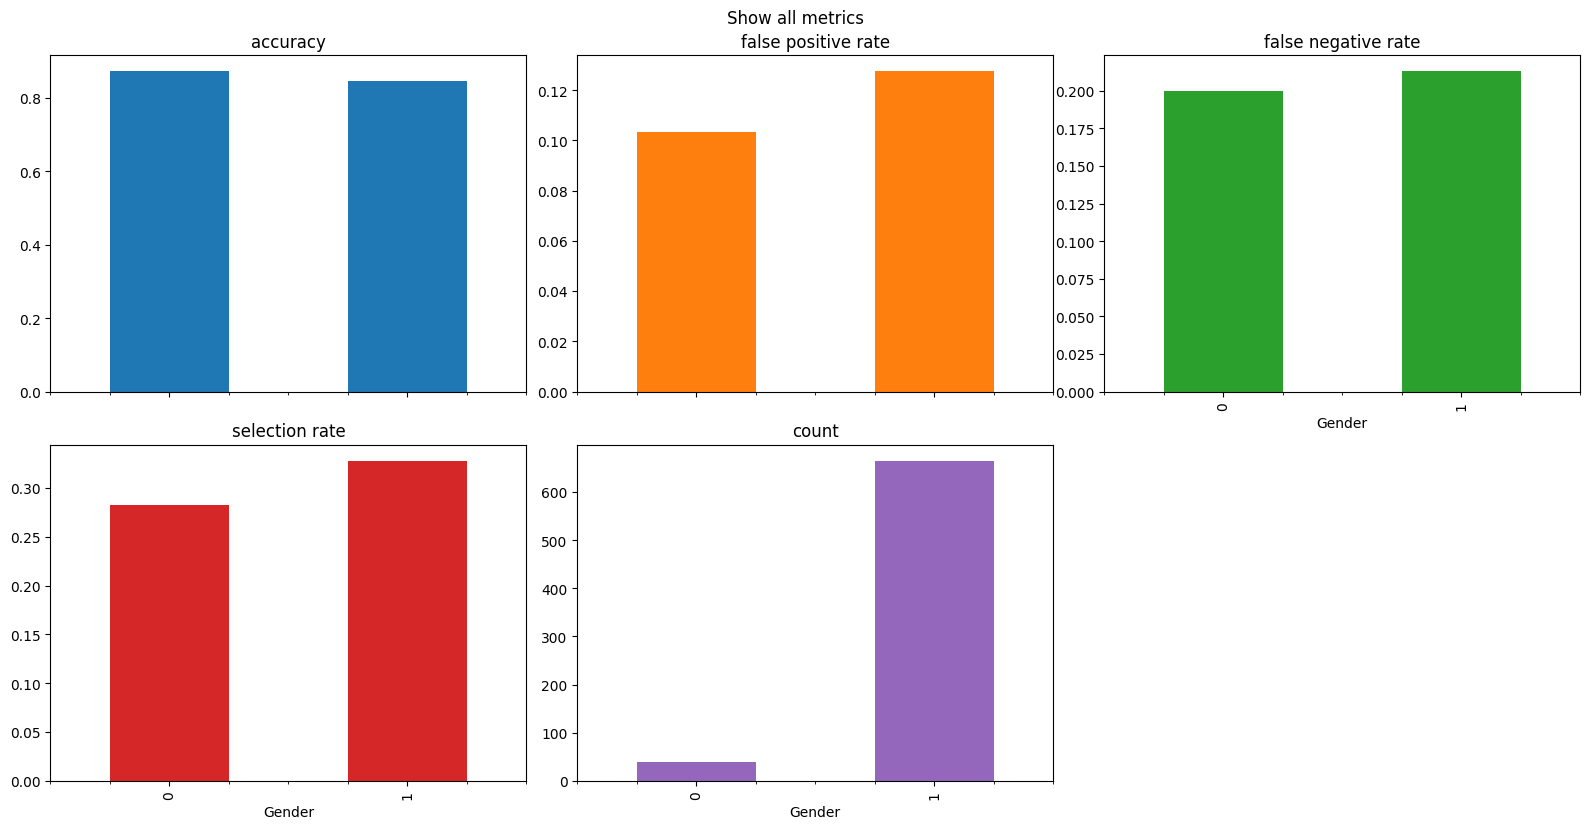

In [111]:
from fairlearn.metrics import (
    MetricFrame,
    count,
    false_negative_rate,
    false_positive_rate,
    selection_rate,
)
from sklearn.metrics import accuracy_score, precision_score

# Analyze metrics using MetricFrame
metrics = {
    "accuracy": accuracy_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
    "count": count,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_test_data
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[16, 12],
    title="Show all metrics",
)
plt.subplots_adjust(
    hspace=0.4,  # Height spacing between subplots
    wspace=0.3,  # Width spacing between subplots
    bottom=0.8  # Bottom margin
)

plt.tight_layout()
plt.show()